![Nuclio logo](https://nuclio.school/wp-content/uploads/2018/12/nucleoDS-newBlack.png)

## 1. Librerias & Google Drive

Para empezar carguemos esas librerias que nos hacen falta

In [ ]:
from tensorflow import keras as ks
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
import tensorflow as tf


from tensorflow.keras.models import Model

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions


Incorporamos la carpeta de Google Drive para poder "guardar" nuestros modelos

1. Abrir barra lateral de Carpeta
2.  Hacer click en carpeta con logo de Google Drive


In [ ]:
# Aquí iria el codigo para conectarse a Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Montar la red neuronal 

In [ ]:
# Creemos una red que será extracción de features basada en VGG16 entrenada con ImageNet

In [ ]:
initializer = ks.initializers.he_normal()
input_tensor = ks.Input(shape=(32, 32, 3))
resized_images = ks.layers.Lambda(lambda image: tf.image.resize(image, (224, 224)))(input_tensor)


In [ ]:
ResNet50 = ks.applications.ResNet50(include_top=False, weights='imagenet', input_tensor=resized_images, input_shape=(224,224,3), pooling='max')

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
ResNet50.summary()


Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 lambda (Lambda)                (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['lambda[0][0]']                 
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                          

In [ ]:
output = ResNet50.layers[-1].output
new_output_layer = ks.layers.Flatten()(output)
ResNet50 = Model(ResNet50.input, new_output_layer)

In [ ]:
ResNet50.summary() 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 lambda (Lambda)                (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['lambda[0][0]']                 
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                             

In [ ]:
# Veamos como va lo de "congelar" capas de entrenamiento

print(ResNet50.trainable)

True


In [ ]:
pd.set_option('max_colwidth', None) 
layers= [(layer, layer.name, layer.trainable) for layer in ResNet50.layers]
pd.DataFrame(layers, columns=['Layer type','Name', 'Trainable?'])

,Layer type,Name,Trainable?
0,<keras.engine.input_layer.InputLayer object at 0x7fac889fb250>,input_1,True
1,<keras.layers.core.lambda_layer.Lambda object at 0x7fac889fb350>,lambda,True
2,<keras.layers.convolutional.ZeroPadding2D object at 0x7fac8dfa8990>,conv1_pad,True
3,<keras.layers.convolutional.Conv2D object at 0x7fac889b1c10>,conv1_conv,True
4,<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fac8df9d950>,conv1_bn,True
...,...,...,...
173,<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fac80279810>,conv5_block3_3_bn,True
174,<keras.layers.merge.Add object at 0x7fac80285750>,conv5_block3_add,True
175,<keras.layers.core.activation.Activation object at 0x7fac80285350>,conv5_block3_out,True
176,<keras.layers.pooling.GlobalMaxPooling2D object at 0x7fac8058e0d0>,max_pool,True


In [ ]:
flag_trainable = False

for layer in ResNet50.layers:
  if layer.name == 'conv3_block4_add':
    flag_trainable = True
  layer.trainable = flag_trainable

In [ ]:
layers= [(layer, layer.name, layer.trainable) for layer in ResNet50.layers]
pd.DataFrame(layers, columns=['Layer type','Name', 'Trainable?'])


,Layer type,Name,Trainable?
0,<keras.engine.input_layer.InputLayer object at 0x7fac889fb250>,input_1,False
1,<keras.layers.core.lambda_layer.Lambda object at 0x7fac889fb350>,lambda,False
2,<keras.layers.convolutional.ZeroPadding2D object at 0x7fac8dfa8990>,conv1_pad,False
3,<keras.layers.convolutional.Conv2D object at 0x7fac889b1c10>,conv1_conv,False
4,<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fac8df9d950>,conv1_bn,False
...,...,...,...
173,<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fac80279810>,conv5_block3_3_bn,True
174,<keras.layers.merge.Add object at 0x7fac80285750>,conv5_block3_add,True
175,<keras.layers.core.activation.Activation object at 0x7fac80285350>,conv5_block3_out,True
176,<keras.layers.pooling.GlobalMaxPooling2D object at 0x7fac8058e0d0>,max_pool,True


##Tomo los datos de mis imagenes cifar10

In [ ]:
cifar10 = ks.datasets.cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train_scaled, x_test_scaled = x_train / 255.0, x_test / 255.0

170508288/170498071 [==============================] - 13s 0us/step


In [ ]:
y_train = y_train.ravel()



In [ ]:
y_test = y_test.ravel()



In [ ]:
x_val_scaled = x_train_scaled[-10000:]
y_val = y_train[-10000:]

x_train_scaled = x_train_scaled[:-10000]
y_train_scaled = y_train[:-10000]


In [ ]:
x_val = x_train[-10000:]


In [ ]:
x_train = x_train[:-10000]

In [ ]:
y_train = y_train[:-10000]

In [ ]:
# Validamos el resultado
print('Train: X=%s, y=%s' % (x_train_scaled.shape, y_train_scaled.shape))
print('Test: X=%s, y=%s' % (x_test_scaled.shape, y_test.shape))
print('Validation: X=%s, y=%s' % (x_val_scaled.shape, y_val.shape))

Train: X=(40000, 32, 32, 3), y=(40000,)
Test: X=(10000, 32, 32, 3), y=(10000,)
Validation: X=(10000, 32, 32, 3), y=(10000,)


In [ ]:
cifar10_labels = [
'airplane', # id 0
'automobile',
'bird',
'cat',
'deer',
'dog',
'frog',
'horse',
'ship',
'truck'
]

print('Number of labels: %s' % len(cifar10_labels))

Number of labels: 10


# Montamos la red VGG que tenemos arriba + mi capa de clasificacion 

In [ ]:
output_from_resnet = 2048 #TODO


In [ ]:
model_with_resnet = ks.Sequential()

# Apilaremos primero la ResNet50
model_with_resnet.add(ResNet50)
kernel_initializer='he_uniform'

model_with_resnet.add(ks.layers.Dense(512, activation='relu',input_shape=(output_from_resnet, )))
model_with_resnet.add(ks.layers.Dense(256, activation='relu'))
model_with_resnet.add(ks.layers.Dropout(0.5))
model_with_resnet.add(ks.layers.Dense(128, activation='relu'))


model_with_resnet.add(ks.layers.Dropout(0.6))
model_with_resnet.add(ks.layers.Dense(10, activation='softmax'))

model_with_resnet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 10)                1

In [ ]:
'''model_with_resnet = ks.Sequential()

model_with_resnet.add(ks.layers.Dense(512, activation='relu',input_shape=(output_from_resnet, )))
model_with_resnet.add(ks.layers.Dropout(0.7))
model_with_resnet.add(ks.layers.Dense(128, activation='relu'))
model_with_resnet.add(ks.layers.Dropout(0.5))
model_with_resnet.add(ks.layers.Dense(64, activation='relu'))
model_with_resnet.add(ks.layers.Dropout(0.3))
model_with_resnet.add(ks.layers.Dense(10, activation='softmax'))
'''

"model_with_resnet = ks.Sequential()\n\nmodel_with_resnet.add(ks.layers.Dense(512, activation='relu',input_shape=(output_from_resnet, )))\nmodel_with_resnet.add(ks.layers.Dropout(0.7))\nmodel_with_resnet.add(ks.layers.Dense(128, activation='relu'))\nmodel_with_resnet.add(ks.layers.Dropout(0.5))\nmodel_with_resnet.add(ks.layers.Dense(64, activation='relu'))\nmodel_with_resnet.add(ks.layers.Dropout(0.3))\nmodel_with_resnet.add(ks.layers.Dense(10, activation='softmax'))\n"

## 3. Optimizador, función error


In [ ]:
from tensorflow.keras.optimizers import Adam

In [ ]:
new_adam = Adam(learning_rate=2e-5) 


In [ ]:
model_with_resnet.compile(loss='sparse_categorical_crossentropy', optimizer=new_adam, metrics=['accuracy'])

##Callbacks

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
callback_earlystopping = EarlyStopping(monitor='val_loss', patience=10)


##Model checkpoint

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint


In [ ]:
callback_modelcheckpoint = ModelCheckpoint('/tmp/modelchk', monitor='val_accuracy', 
                                           verbose=1, save_best_only=True, 
                                           save_weights_only=True)

## 5. Entrenamiento

Ya podemos ponernos a entrenar el modelo!! Ojo, que hemos de entrenar contra los datos convertidos al formato que espera la Convolution.

Empezaremos con 30 epocs, es decir, 30 pasadas completas del dataset (que a su vez sera con mini-batches internamente), fijando un batch de 64

El metodo .fit() nos permite, definir además si disponemos de varias CPUs, GPUs, y si queremos ir validando datos a cada fin de epoch.

In [ ]:
history = model_with_resnet.fit(x=x_train_scaled, y=y_train, batch_size=32,
                             epochs=50, callbacks=[callback_modelcheckpoint, callback_earlystopping], 
                             validation_data=(x_val_scaled, y_val))

## 6. Evaluamos los resultados

Obtengamos una grafica de como el error y la accuracy van evolucionando en cada epoch en los datos de entrenamiento y en la validación

In [ ]:
_, acc = model_with_resnet.evaluate(x_test_scaled, y_test, verbose=0)
print('> %.3f' % (acc * 100.0))

> 75.180


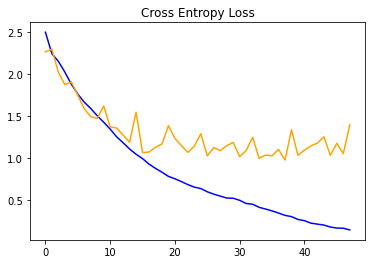

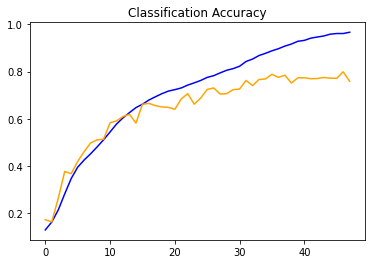

In [ ]:
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='val')
plt.show()

plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='orange', label='val')
plt.show()

Veamos que tipo de predicciones estoy obteniendo sobre el conjunto de test (vamos a pintar las imagenes y sus clasificaciones)

In [ ]:
predictions = model_with_resnet.predict(x_test)

Una de las ventajas de Python es que hay montones de funciones y código realizado por terceras personas. Aquí me he fusilado unas bonitas funciones (que he adaptado un poco a mis necesidades) para poder pintar las imagenes, su label (ground truth) y las clasificaciones que hemos realizado.

## 7. Guardamos el modelo para futuras evaluaciones

Id cambiando los nombres del archivo para ir guardando los diversos proyectos.
Aquí lo guardamos en "local", pero recordad que lo ideal es que lo guardeis en Google Drive (teneis que montar la unidad, fijar la ruta y allí guardar el modelo .h5)

In [ ]:
ruta_googledrive = "/content/drive/MyDrive/" # A revisar en vuestra instancia

model.save(ruta_googledrive+'cifar10_base_model.h5')

NameError: ignored